# Libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load Data

In [4]:
batch_size = 64

train_dataset = datasets.MNIST(root = "dataset/", train = True, transform=transforms.ToTensor(), download= True)
train_loader = DataLoader(dataset = train_dataset, batch_size= batch_size, shuffle= True)

test_dataset = datasets.MNIST(root = "dataset/", train = False, transform=transforms.ToTensor(), download= True)
test_loader = DataLoader(dataset = test_dataset, batch_size= batch_size, shuffle= True)

# define the model

## NN

In [5]:
class NN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 50)
        self.fc2 = nn.Linear(50, num_classes)
    
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    

model = NN(784, 10)
x = torch.randn(64, 784)
print(model(x).shape)

torch.Size([64, 10])


## CNN

In [6]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels = 8, kernel_size = (3,3), stride = (1,1), padding = (1,1))
        self.pool = nn.MaxPool2d(kernel_size = (2,2), stride = (2,2))
        self.conv2 = nn.Conv2d(8, out_channels = 16, kernel_size = (3,3), stride = (1,1), padding = (1,1))
        self.fc1 = nn.Linear(7*7*16, num_classes)

    def forward(self, x):
        # print(self.conv1)
        # print(x.shape)
        x = F.relu(self.conv1(x))
        # print(x.shape)
        x = self.pool(x)
        # print(x.shape)
        x = F.relu(self.conv2(x))
        # print(x.shape)
        x = self.pool(x)
        # print(x.shape)
        x = x.reshape(x.shape[0], -1)
        # print(x.shape)
        x = self.fc1(x)

        return x

model = CNN(1, 10)
x = torch.randn(64, 1, 28, 28)
print(model(x).shape)


torch.Size([64, 10])


# Hyperparameters

In [7]:
#for CNN
in_channels = 1 
#for NN
input_size = 784 

# for both
num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 4
loss_fn = nn.CrossEntropyLoss()

# Train

In [ ]:
def train(model, train_loader, valid_loader, loss_fn, optimizer, n_epochs):
    for epoch in range(1, n_epochs+1):
        # Keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        train_accuracy = 0.0
        valid_accuracy = 0.0

        
        # Train the model
        model.train()
        for data in train_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*inputs.size(0)
            train_accuracy += (outputs.argmax(1) == labels).type(torch.float).sum().item()
        
        # Evaluate the model
        model.eval()
        for data in valid_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            valid_loss += loss.item()*inputs.size(0)
            valid_accuracy += (outputs.argmax(1) == labels).type(torch.float).sum().item()
        
        # Calculate average losses
        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(valid_loader.dataset)
        train_accuracy = train_accuracy/len(train_loader.dataset)
        valid_accuracy = valid_accuracy/len(valid_loader.dataset)

        # save the model each 5 epochs
        if epoch % 5 == 0:
            torch.save(model.state_dict(), f'model_{epoch}.pt')
        
        print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f} | Training Accuracy: {train_accuracy:.6f} | Validation Loss: {valid_loss:.6f} | Validation Accuracy: {valid_accuracy:.6f}')

# Test

In [9]:
def test(dataloader, model, loss_fn):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:

            X = X.to(device)
            y = y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()

            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

# Run

In [13]:
# Init the model
modelNN = NN(input_size=input_size, num_classes=num_classes).to(device)
# Train the model
history = train(train_loader, modelNN, num_epochs, loss_fn, learning_rate)
# Test the model
test(train_loader, modelNN, loss_fn)
test(test_loader, modelNN, loss_fn)

Epoch 0 batch 0 loss 2.3164
Epoch 0 batch 50 loss 0.8973
Epoch 0 batch 100 loss 0.4530
Epoch 0 batch 150 loss 0.4619
Epoch 0 batch 200 loss 0.4508
Epoch 0 batch 250 loss 0.5095
Epoch 0 batch 300 loss 0.2414
Epoch 0 batch 350 loss 0.1727
Epoch 0 batch 400 loss 0.2822
Epoch 0 batch 450 loss 0.2896
Epoch 0 batch 500 loss 0.3294
Epoch 0 batch 550 loss 0.2765
Epoch 0 batch 600 loss 0.2711
Epoch 0 batch 650 loss 0.2085
Epoch 0 batch 700 loss 0.2591
Epoch 0 batch 750 loss 0.2355
Epoch 0 batch 800 loss 0.2276
Epoch 0 batch 850 loss 0.1464
Epoch 0 batch 900 loss 0.3562
Epoch 1 batch 0 loss 0.2313
Epoch 1 batch 50 loss 0.2728
Epoch 1 batch 100 loss 0.1785
Epoch 1 batch 150 loss 0.1313
Epoch 1 batch 200 loss 0.1948
Epoch 1 batch 250 loss 0.2090
Epoch 1 batch 300 loss 0.3156
Epoch 1 batch 350 loss 0.2841
Epoch 1 batch 400 loss 0.1701
Epoch 1 batch 450 loss 0.1604
Epoch 1 batch 500 loss 0.1671
Epoch 1 batch 550 loss 0.1422
Epoch 1 batch 600 loss 0.2245
Epoch 1 batch 650 loss 0.1704
Epoch 1 batch 70

In [197]:
modelCNN = CNN(in_channels=in_channels, num_classes=num_classes).to(device)
history = train(train_loader, modelCNN, num_epochs, loss_fn, learning_rate)
test(train_loader, modelCNN, loss_fn)
test(test_loader, modelCNN, loss_fn)

Epoch 0 batch 0 loss 2.3071
Epoch 0 batch 50 loss 1.5394
Epoch 0 batch 100 loss 0.5529
Epoch 0 batch 150 loss 0.4190
Epoch 0 batch 200 loss 0.4502
Epoch 0 batch 250 loss 0.3449
Epoch 0 batch 300 loss 0.4720
Epoch 0 batch 350 loss 0.3061
Epoch 0 batch 400 loss 0.1947
Epoch 0 batch 450 loss 0.1433
Epoch 0 batch 500 loss 0.1132
Epoch 0 batch 550 loss 0.1636
Epoch 0 batch 600 loss 0.1167
Epoch 0 batch 650 loss 0.0961
Epoch 0 batch 700 loss 0.0881
Epoch 0 batch 750 loss 0.1687
Epoch 0 batch 800 loss 0.1094
Epoch 0 batch 850 loss 0.1835
Epoch 0 batch 900 loss 0.0348
Test Error: 
 Accuracy: 96.5%, Avg loss: 0.118504 

Test Error: 
 Accuracy: 96.8%, Avg loss: 0.106373 



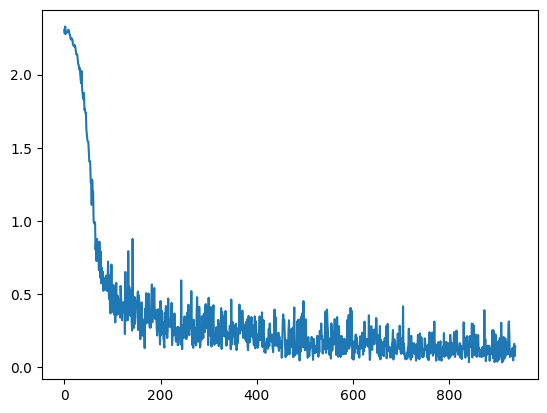

In [198]:
import matplotlib.pyplot as plt
plt.plot(history)

# load model from a checkpoint

In [14]:
model = NN(input_size=input_size, num_classes=num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)


checkpoint = torch.load("checkpoint.pth")
model.load_state_dict(checkpoint["model"])
optimizer.load_state_dict(checkpoint["optimizer"])

test(test_loader, model, loss_fn)

Test Error: 
 Accuracy: 94.7%, Avg loss: 0.183153 

